In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pymannkendall as mk
from src.plot_utils import *
from scipy.stats import linregress
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=12)

df = pd.read_csv('../results/lulcTrend_vs_hsTrend.csv')

In [17]:
# estimate annual trend of urbanization, BFI, runoff_ratio, and stream_elas
def estimate(x):
    x = x.sort_values('year')
    corr0 = x[['ImperviousSurface','runoff_ratio','baseflow_mean','BFI','stream_elas']].corr(method='spearman')
    r_rr = corr0.loc['ImperviousSurface','runoff_ratio']
    r_base = corr0.loc['ImperviousSurface','baseflow_mean']
    r_BFI = corr0.loc['ImperviousSurface','BFI']
    r_elas = corr0.loc['ImperviousSurface','stream_elas']
    mk0 = mk.pre_whitening_modification_test(x.ImperviousSurface.values)
    mk1 = mk.pre_whitening_modification_test(x.runoff_ratio.values)
    mk2 = mk.pre_whitening_modification_test(x.BFI.values)
    mk3 = mk.pre_whitening_modification_test(x.stream_elas.values)
    mk4 = mk.pre_whitening_modification_test(x.baseflow_mean.values)
    slope_urban, p_urban = mk0.slope, mk0.p
    slope_rr, p_rr = mk1.slope, mk1.p
    slope_BFI, p_BFI = mk2.slope, mk2.p
    slope_elas, p_elas = mk3.slope, mk3.p
    slope_baseflow, p_baseflow = mk4.slope, mk4.p
#     slope_urban, intercept, r_value, p_urban, std_err = linregress(x.year.values, x.ImperviousSurface.values)
#     slope_BFI, intercept, r_value, p_BFI, std_err = linregress(x.year.values, x.BFI.values)
#     slope_rr, intercept, r_value, p_rr, std_err = linregress(x.year.values, x.runoff_ratio.values)
#     slope_elas, intercept, r_value, p_elas, std_err = linregress(x.year.values, x.stream_elas.values)
#     slope_forest, intercept, r_value, p_forest, std_err = linregress(x.year.values, x.forest.values)
    return pd.Series([
        r_rr, r_base, r_BFI, r_elas,
        slope_urban, p_urban,
        slope_BFI, p_BFI,
        slope_rr, p_rr,
        slope_elas, p_elas,
        slope_baseflow, p_baseflow
#         slope_forest, p_forest
    ], index = ['r_rr','r_base','r_BFI','r_elas','slope_urban','p_urban','slope_BFI','p_BFI','slope_rr','p_rr','slope_elas','p_elas','slope_baseflow','p_baseflow'
#                 'slope_forest','p_forest',
               ])
df_ave = df.groupby(['ohdb_id','aridity','climate_label']).p_apply(estimate).reset_index()

ESTIMATE DONE:   0%|          | 0/6216 [00:00<?, ?it/s]

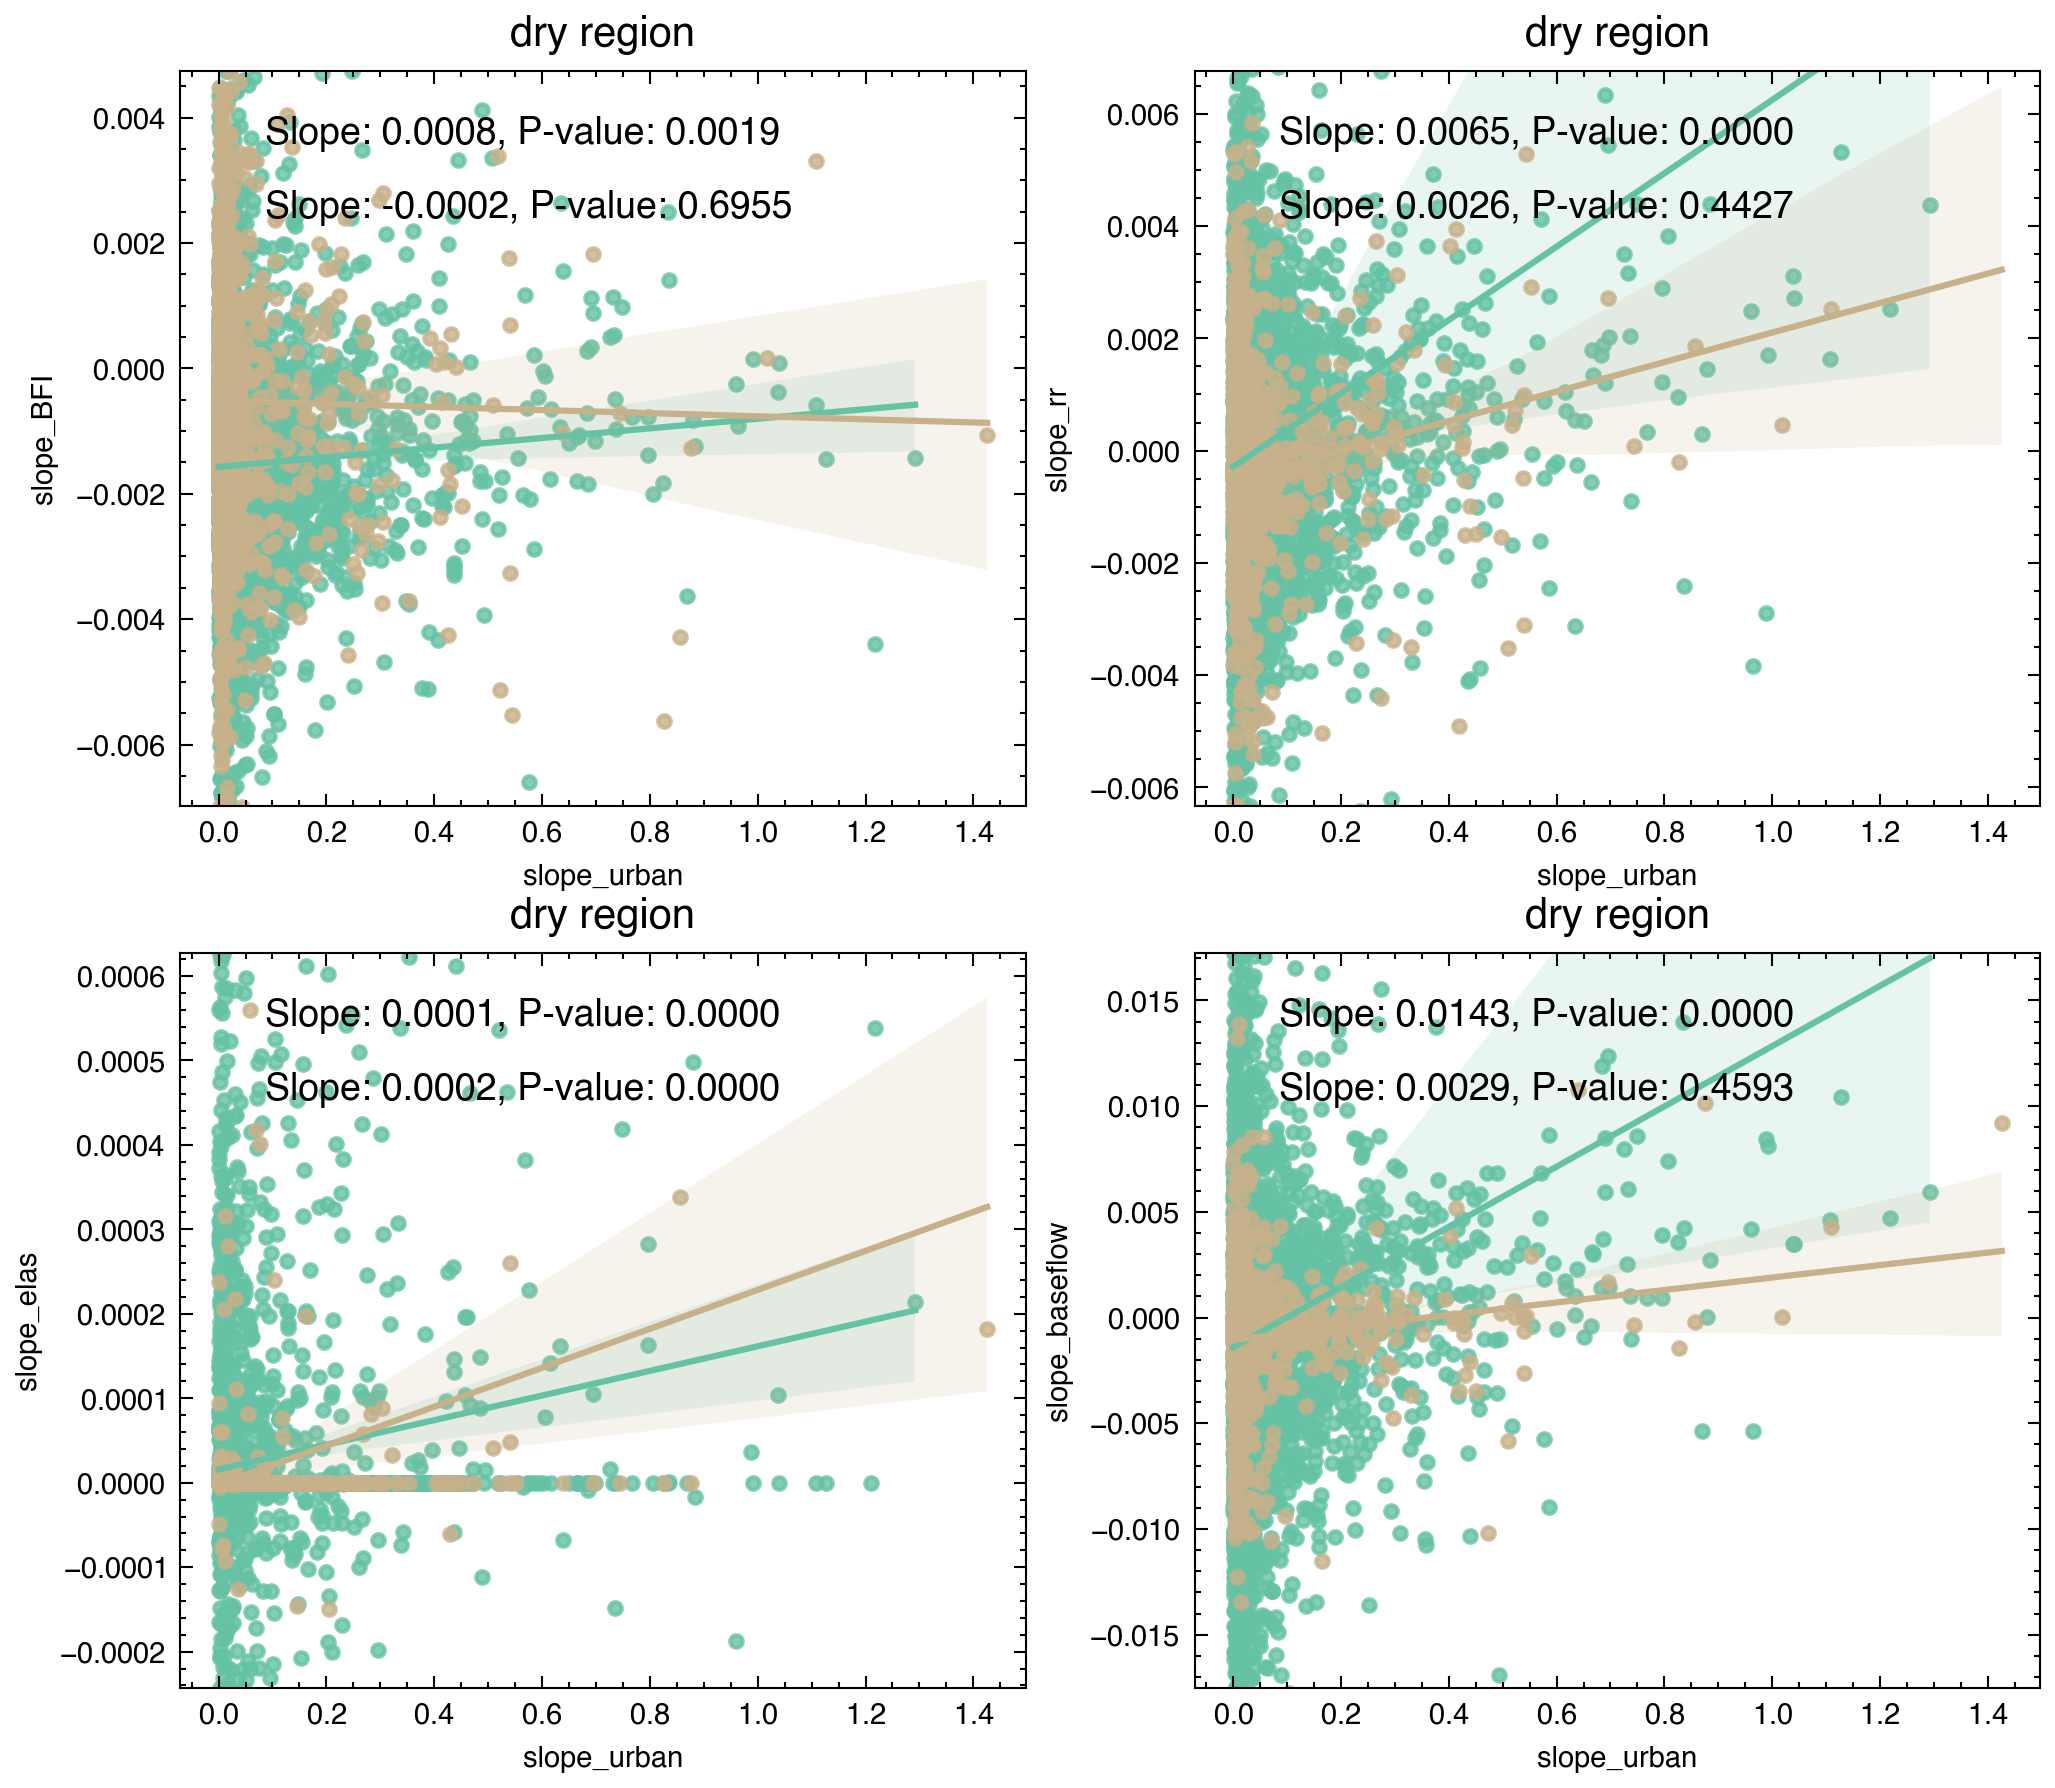

In [34]:
df_ave = df_ave.loc[(df_ave.p_urban<=0.05),:]
df_ave['catch'] = np.where(df_ave.aridity<=0.65, 'dry', 'wet')

fig, axes = plt.subplots(2, 2, figsize = (8, 7), dpi = 300)
for i,name in enumerate(['BFI','rr','elas','baseflow']):
    ax = axes.ravel()[i]
    for j,catch in enumerate(df_ave.catch.unique()):
        df_ave0 = df_ave.loc[df_ave.catch==catch,['slope_urban','slope_'+name]].dropna()
        sns.regplot(
            data = df_ave0,
            x = 'slope_urban',
            y = 'slope_'+name,
            ax = ax,
            color = palette['dry'] if catch=='dry' else palette['temperate'],
        )
        slope, intercept, r_value, p_value, std_err = linregress(df_ave0.slope_urban.values, df_ave0['slope_'+name].values)
        if j == 0:
            y = 0.9
        else:
            y = 0.8
        ax.text(.1, y, f"Slope: {slope:.4f}, P-value: {p_value:.4f}", transform = ax.transAxes, fontsize = 9)
        ax.set_title(f'{catch} region', fontsize = 10)
    ax.set_ylim(df_ave['slope_'+name].quantile([.01,.99]))
    
# name = 'BFI'
# sns.scatterplot(df_ave, x = 'slope_urban', y = 'slope_'+name, hue = 'climate_label', ax = ax)
# ax.set_xscale('log')

In [19]:
df = pd.read_csv('../results/high_flow_classification.csv')
df['catch'] = np.where(df.aridity.values<=0.65, 'dry', 'wet')


In [20]:
df.groupby('catch').apply(lambda x:x.loc[x.classification=='excess rain flood',:].shape[0]/x.shape[0])


catch
dry    0.135785
wet    0.015138
dtype: float64

In [21]:
df.groupby('climate_label').apply(lambda x:x.groupby('classification').count())

,count,unique,top,freq
climate_label,,,,
cold,416360,5,stratiform rain flood,220740
dry,119931,5,stratiform rain flood,67296
temperate,593794,5,stratiform rain flood,330240
tropical,98055,5,stratiform rain flood,69065


<Axes: xlabel='r_rr', ylabel='Proportion'>

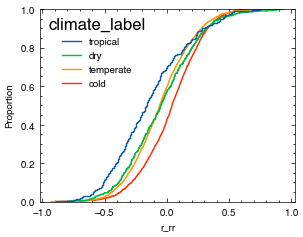

In [21]:
df_ave['catch'] = np.where(df_ave.aridity.values<=0.65, 'dry', 'wet')
sns.ecdfplot(df_ave, x = 'r_rr', hue = 'climate_label')

In [47]:
df = pd.read_csv('../results/lulcTrend_vs_hsTrend.csv')
def func(x):
    mk0 = mk.pre_whitening_modification_test(x.sort_values('year').ImperviousSurface.values)
    slope1, intercept, r_value, p_value1, std_err = linregress(x.ImperviousSurface.values, x.runoff_ratio.values)
    slope2, intercept, r_value, p_value2, std_err = linregress(x.ImperviousSurface.values, x.BFI.values)
    return pd.Series([slope1, p_value1, slope2, p_value2, mk0.slope, mk0.p], index = ['slope_rr','p_rr','slope_BFI','p_BFI','slope','p'])
df1 = df.groupby(['ohdb_id','climate_label','aridity']).apply(func).reset_index()

<Axes: xlabel='climate_label', ylabel='slope_BFI'>

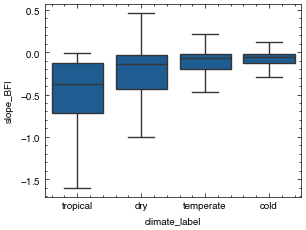

In [48]:
name = 'BFI'
df1 = df1.loc[(df1.slope>0)&(df1.p<=0.05),:]
sns.boxplot(df1.loc[df1['p_'+name]<=0.05,:], y = 'slope_'+name, x = 'climate_label', showfliers = False )

(-5.0, 5.0)

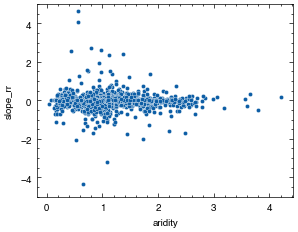

In [58]:
sns.scatterplot(df1.loc[df1.p_BFI<=0.05,:], x = 'aridity', y = 'slope_rr')
plt.ylim(-5, 5)

In [56]:
df1['tmp'] = pd.cut(df1.aridity.values, bins = [0, 0.5, 1, 1.5, 2, 5])
df1.loc[df1.p_rr<=0.05,:].groupby('tmp')['slope_rr'].describe()

,count,mean,std,min,25%,50%,75%,max
tmp,,,,,,,,
"(0.0, 0.5]",191.0,0.264470,2.708362,-3.466582,-0.137450,0.002488,0.128713,30.295576
"(0.5, 1.0]",554.0,-0.019070,0.569962,-4.330758,-0.115351,-0.019564,0.032665,4.951279
"(1.0, 1.5]",251.0,-0.051687,0.443289,-3.187889,-0.144292,-0.038884,0.044617,1.509124
"(1.5, 2.0]",60.0,0.308124,2.673838,-2.008135,-0.135204,-0.037973,0.171927,20.314347
"(2.0, 5.0]",31.0,-0.148141,0.568681,-1.716060,-0.253193,-0.075901,0.020485,1.172737


In [14]:
from src.plot_utils import *
from pathlib import Path
import json,string
from scipy import stats
from scipy.stats import linregress
from tqdm import tqdm
import pickle

dir_Qmax7 = Path('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/')
dir_Qmin7 = Path('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/')

with open(dir_Qmax7 / 'cfg.json', 'r') as fp:
    cfg_Qmax7 = json.load(fp)
with open(dir_Qmin7 / 'cfg.json', 'r') as fp:
    cfg_Qmin7 = json.load(fp)

predictors = cfg_Qmax7['meteo_name'] + cfg_Qmax7['lulc_name'] + cfg_Qmax7['attr_name']

idx = predictors.index('ImperviousSurface')
idx_smrz = predictors.index('smrz')

def read(par):
    name, seed = par
    try:
        inter0 = pickle.load(open(eval('dir_'+name) / f'xgb_onlyUrban_shap_interaction_values_explain_{seed}.pkl', 'rb'))
    except:
        return

    tmp = pd.DataFrame(data = np.abs(inter0[:,idx,:]), columns = predictors)
    tmp['max_inter_feature'] = tmp.idxmax(axis=1)
    tmp['max_inter_value'] = tmp.iloc[:,:-1].max(axis=1)

    # interaction bewteen urban area and soil moisture
    tmp['inter_urban_smrz'] = inter0[:, idx, idx_smrz]
    tmp['rank_urban_smrz'] = tmp.iloc[:,:-3].rank(1)['smrz'].values

    tmp = tmp[[
        'rank_urban_smrz',
        'inter_urban_smrz',
        'max_inter_value',
        # 'max_inter_feature'
    ]]
    return tmp

if __name__ == '__main__':
    name = 'Qmax7'
    seeds = [str(s).split('_')[-1].split('.')[0] for s in dir_Qmax7.glob('*shap_interaction_values_explain_*pkl')][:10]
    with mp.Pool(4) as p:
        df_Qmax7 = list(tqdm(p.imap(read, [(name,seed) for seed in seeds])))
    df_Qmax7 = [a for a in df_Qmax7 if a is not None]
    df_Qmax7 = sum(df_Qmax7) / len(df_Qmax7)
    tmp = pd.read_pickle(cfg_Qmax7['fname'])
    df_Qmax7 = pd.concat([df_Qmax7, tmp[['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label','aridity']]], axis = 1)
#     df_Qmax7 = df_Qmax7.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label','aridity']).mean().reset_index()

    name = 'Qmin7'
    seeds = [str(s).split('_')[-1].split('.')[0] for s in dir_Qmin7.glob('*shap_interaction_values_explain_*pkl')][:10]
    with mp.Pool(4) as p:
        df_Qmin7 = list(tqdm(p.imap(read, [(name,seed) for seed in seeds])))
    df_Qmin7 = [a for a in df_Qmin7 if a is not None]
    df_Qmin7 = sum(df_Qmin7) / len(df_Qmin7)
    tmp = pd.read_pickle(cfg_Qmin7['fname'])
    df_Qmin7 = pd.concat([df_Qmin7, tmp[['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label','aridity']]], axis = 1)
#     df_Qmin7 = df_Qmin7.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label','aridity']).mean().reset_index()

10it [01:57, 11.78s/it]
10it [03:21, 20.12s/it]


In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))
for i,name in enumerate(['Qmin7', 'Qmax7']):
    df1 = eval('df_'+name)
    ax = axes[i,0]
    df1['catch'] = np.where(df1.aridity.values <= 0.65, 'dry', 'wet')
    sns.ecdfplot(df1, x = 'rank_urban_smrz', hue = 'climate_label', ax = ax)
    ax.set_xlabel('Rank of SHAP interaction values between\nurban area and soil moisture', fontsize = 9)
    sns.move_legend(ax, 'upper left', title = None)
    ax.text(-.1, 1, string.ascii_letters[(i+1)*2-2], weight = 'bold', transform = ax.transAxes, fontsize = 10)
    ax.tick_params(axis = 'both', labelsize = 9)

    ax2 = axes[i,1]
    sns.regplot(df1, x = 'aridity', y = 'rank_urban_smrz', ax = ax2, line_kws={'color': 'red'}, robust = True)
    ax2.set_xlabel('Catchment aridity', fontsize = 9)
    ax2.set_ylabel('Rank of SHAP interaction values between\nurban area and soil moisture', fontsize = 9)
    ax2.tick_params(axis = 'both', labelsize = 9)
    slope, intercept, r_value, p_value, std_err = linregress(df1.aridity.values, df1.rank_urban_smrz.values)
    ax2.text(.95,.05,f'r = {r_value:.2f} p = {p_value:.3f}', transform = ax2.transAxes, ha = 'right')
    ax2.text(-.1, 1, string.ascii_letters[(i+1)*2-1], weight = 'bold', transform = ax2.transAxes, fontsize = 10)

fig.tight_layout()
# fig.savefig(dir_Qmax7 / 'fig4.png', dpi = 600)